# Cantera module for Flamelet Generated Manifolds
We are going to run a series of free flames, visualise them and create an FGM for ANSYS Fluent. 
As always, go through this interactive notebook in jupyter (jupyter labs or jupyter notebook), read carefully what we do, try to understand the piece of code and follow the instructions. 
You can execute the selected cell one by one using the play button at the top or pressing SHIFT+ENTER.
First we load the necessary libraries.
For help on the cantera commands see https://cantera.org/documentation/

In [1]:
# use this for standard jupyter notebook visualization
%matplotlib inline

# with a local install you can use qt5 and get pop-up windows with interactive graphics (pan, zoom, edit)
#%matplotlib qt5

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import csv

We have seen previously that cantera uses local grid adaptation and the final flame solution does not have a fixed number of grid points in the x-direction. If we are going to convert the data f(x) to f(c), where c is the progress variable, then we also have a variable number of points in the progress variable direction. We want to have solutions with a fixed number of points so it can be easily stored in an array, eg. an array with 200 points in progress variable direction and 100 points in the enthalpy direction.
We will need some interpolation routines to create results with the same number of points in the progress variable direction.

In [3]:
# linearly interpolate and get T at point p using input data (x,T)
def interpoint(p,x,T):
    if (p<x[0] or p>x[len(x)-1]):
        raise ValueError("point p=",p," is not inside the domain with boundaries [",x[0],",",x[len(x)-1],")")
    # immediately return correct value when p is on the boundary
    if (abs(p-x[0])<1.0e-16):
        return(T[0])
    if (abs(p-x[len(x)-1])<1.0e-16):
        return(T[len(x)-1])
    i=0
    Tvalue=0
    pointfound=False
    while((i<(len(x)-1)) and not(pointfound)):       
        if (x[i]<=p and x[i+1]>p) :
            dx = x[i+1]-x[i]
            if (dx==0):
                raise ValueError("two spatial points have the same value! ",x[i+1],x[i])
            dT = T[i+1]-T[i]
            Tvalue=T[i] + (p-x[i]) * (dT/dx)
            pointfound=True
        i=i+1
    return(Tvalue)

# interpolate T at the list of locations xnew using x,T
def interplist(xnew,xold,Told):
    Tnew=[]
    for x in xnew:
        Tnew.append(interpoint(x,xold,Told))
    return(Tnew)

# compute change dT on the input data T
def dT(x,T):
    gradlist=[]
    for i in range(len(T)-1):
        #gradlist.append((T[i+1]-T[i])/(x[i+1]-x[i]))
        # we compute dT*dT so we have always have a positive change
        gradlist.append((T[i+1]-T[i])**2)
    return gradlist

# add a new point at an optimal location according to temperature changes
# we look at the change in T (not dT/dx!) so large elements with small gradients will also be refined
def addoptimal(xcopy,Ycopy,Tcopy,xold,Yold,Told):
    # remember: input arguments are modified if they are lists!
    x = xcopy.copy()
    Y = Ycopy.copy()
    T = Tcopy.copy()
    
    # compute temperature change in y-direction (not dT/dx)
    gT = dT(x,T)
    
    #print("gradients = ",gT)
    # get the maximum change
    gTmax = max(gT)
    # get the index of the cell with the maximum change
    gTmaxindex = np.where(gT == gTmax)[0][0]
    
    #x = np.insert(x,gTmaxindex+1,0.5*(x[gTmaxindex+1]+x[gTmaxindex]))
    #T = np.insert(T,gTmaxindex+1,0.5*(T[gTmaxindex+1]+T[gTmaxindex]))
    
    # use original data for interpolation
    px = 0.5*(x[gTmaxindex+1]+x[gTmaxindex])
    # insert a point in the grid x in the cell with maximum Temperature change
    x = np.insert(x,gTmaxindex+1,px)
    # interpolate value of Y
    T = np.insert(T, gTmaxindex+1, interpoint(px,xold,Told))
    Y = np.insert(Y, gTmaxindex+1, interpoint(px,xold,Yold))

    return x,Y,T

# Our starting point is an array x and Y, with temperature T
# we then create a new initial equidistant mesh xnew and we first interpolate onto the new mesh
# then we want to add points until we have reached the new N
# we use gradients of temperature T a
def newmesh(xold,Yold,Told,N):
    initialN = 10
    if N<(initialN+1):
        raise ValueError("number of points must be larger than ",initialN)
    # initial equidistant mesh distribution
    xnew=np.linspace(xold[0],xold[len(xold)-1],10) 

    Tnew=interplist(xnew,xold,Told)
    # interpolate Ynew on the new mesh xnew
    Ynew=interplist(xnew,xold,Yold)
    
    # now we add points until we reach N points
    for n in range(initialN+1,N+1,1):
        xnew, Ynew,Tnew = addoptimal(xnew,Ynew,Tnew,xold,Yold,Told)
    return xnew,Ynew

With the routines above, specifically with the function *newmesh(xold,myold,Told,N)* we can remesh a solution onto a new mesh with a certain number of gridpoints N. The new mesh will still have a nonuniform distribution of grid points, so more points are added in the region where the temperature changes are larger. This is less advanced than what cantera is doing, but good enough to create our FGM. 


Recall that with FGM, we want to avoid solving all species transport equations and instead solve only one equation that represents all the species: the progress variable. For a given equivalence ratio and (total) enthalpy, the mass fraction of all other species is a unique function of the progress variable. Also the temperature, viscosity, density, etc. are unique function of the progress variable. We compute a 1D free flame and save the information as a function of the progress variable. The definition of the progress variable is not very important, as long as all our quantities can be uniquely identified with the progress variable. During our 2D or 3D computations in Fluent, we solve only the transport equation of the progress variable (together with the flow and energy equations) and retrieve the other species information from our stored 1D results (our lookup table). If the enthalpy changes because of heat losses in the domain (due to e.g. cold walls)  we have to save the result of multiple flame solutions with enthalpies that cover the enthalpy range in our 2D or 3D computation.

Recall our setup of a 1D free flame. Below is the cantera code for a methane-air flame with equivalence ratio $\phi=0.80$ and unity Lewis number. 

In [50]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.03  # width of the domain, from [0,width]
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# Set up flame object
f = ct.FreeFlame(gas, width=width)
# use some mesh refinement
# smaller values are better but take more time and lead to more grid points.
f.set_refine_criteria(ratio=2, slope=0.05, curve=0.09)

# Solve with Unity Lewis transport model
f.transport_model = 'UnityLewis'
f.solve(loglevel=loglevel, auto=True)

print('Done! unity Lewis flamespeed = {0:7f} m/s'.format(f.u[0]))
print('number of gridpoints: ',len(f.u))

Done! unity Lewis flamespeed = 0.246750 m/s
number of gridpoints:  211


We have used Cantera's automatic regridding to get a more optimal solution. More points are added at locations with large gradients in the solution. However, we need a fixed number of points N in progress variable space and a fixed number of points in enthalpy space for our lookup table (else we would not have a nice 'square' table with X\*Y points). The number of points do not have to be equally distributed in the lookup table as long as we have the same number of points in the x-direction and y-direction. Let's first look at the solution and the distribution of the points.

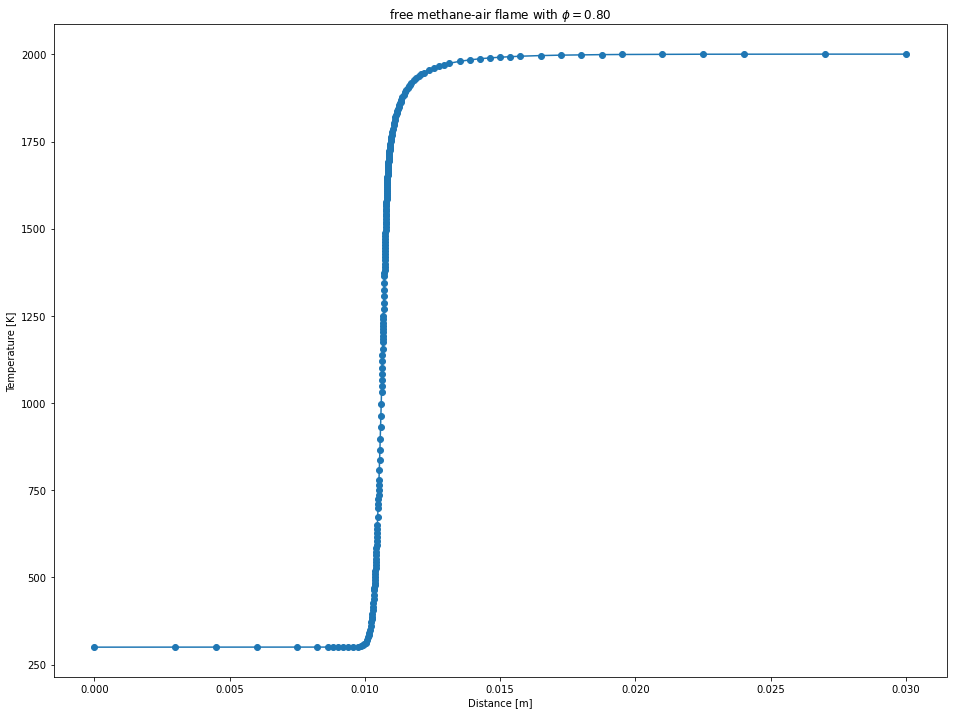

In [51]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [10, 5]

#plt.xlim(0.0,0.024)
plt.plot(f.grid,f.T,'o-')
plt.title('free methane-air flame with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]');


The temperature looks good and we see that more points have been added in the region with the large temperature gradient. Let's also look at the production of CO2.

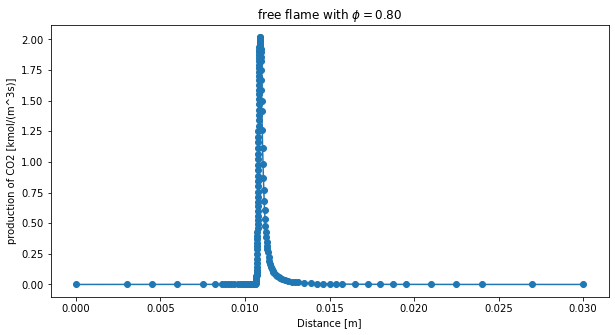

In [52]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [10, 5]
#plt.xlim(0.00,0.024)
plt.plot(f.grid,f.net_production_rates[gas.species_index('CO2')],'o-')
plt.title('free flame with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production of CO2 [kmol/(m^3s)]');

A very steep peak! We see that this peak is captured correctly by the refinement procedure. For the FGM, we need to construct a table with different enthalpies. We can change the enthalpy by changing the initial, unburnt temperature of a free flame, or by lowering the mass burning rate of a burner stabilized flame (so it loses more heat to the burner). Let's first look at changing the initial temperature.

we can also check that the points are nicely distributed in progress variable space:

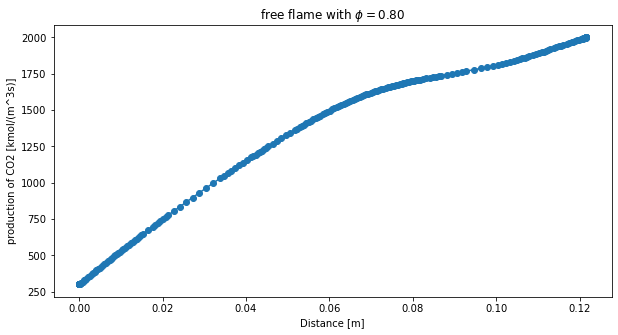

In [57]:
plt.figure()

#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [10, 5]
#plt.xlim(0.00,0.024)
plt.plot(f.Y[gas.species_index('CO2')],f.T,'o-')
plt.title('free flame with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production of CO2 [kmol/(m^3s)]');

In [23]:
# We are going to create an FGM with different enthalpy levels.
# To increase the enthalpy, we can increase the inlet temperature of the mixture. 
# We are going to create a list of flames with unburnt temperatures of T=300,400,500,600
# This will take a couple of minutes to run...

# we compute in order of high to low enthalpy, so it also ends up in the list like that.
T_unburnt_list = [300,400,500,600]

# we store the individual flame solutions in a list of flame solutions
flamelist = []

for T_unburnt in T_unburnt_list:
    print("initial, unburnt temperature = ",T_unburnt)
    # Simulation parameters
    p = ct.one_atm  # pressure [Pa]
    width = 0.03  # m
    loglevel = 0  # amount of diagnostic output (0 to 8)

    gas = ct.Solution('gri30.xml')

    # equivalence ratio 
    phi = 0.80
    fuel_species = 'CH4'
    air_composition='O2:0.21,N2:0.79'
    gas.TP = T_unburnt,p
    gas.set_equivalence_ratio(phi,fuel_species,air_composition)

    # Set up flame object
    flame = ct.FreeFlame(gas, width=width)
    flame.set_refine_criteria(ratio=2, slope=0.04, curve=0.08)
    #f.show_solution()

    # Solve with Unity Lewis transport model
    flame.transport_model = 'UnityLewis'
    #flame.solve(loglevel=loglevel, auto=True)
    flame.solve(loglevel) # don't use 'auto' on subsequent solves
    #we save the enthalpy from lowest to highest
    flamelist.append(flame)
    print("flame enthalpy = ",flame.enthalpy_mass[0])
    print("number of points = ",len(flame.enthalpy_mass))
    
print("We are done here!")

initial, unburnt temperature =  300
flame enthalpy =  -205502.97447552579
number of points =  248
initial, unburnt temperature =  400
flame enthalpy =  -97884.36411529974
number of points =  237
initial, unburnt temperature =  500
flame enthalpy =  12569.010084188556
number of points =  234
initial, unburnt temperature =  600
flame enthalpy =  126423.02507541931
number of points =  231
We are done here!


We have computed a couple of flames with different total enthalpies. Given a local progress variable (mass fraction of $CO_2$) and total enthalpy, we can get the unique local composition: the mass fractions and other gas properties like temperature and viscosity. It is unique for a specific gas (methane-air) with a specific fuel-air mixture ($\phi=0.80$). If we do not have any heat losses (adiabatic flame), then the composition of a 2D or 3D flame can be described completely by a single 1D flame computation. The only thing we need to compute in 2D or 3D is the flow equations, the total enthalpy equation and a transport equation for the progress variable. 
Depending on the amount of heat loss we might need more flame solutions with a lower enthalpy. We see from the free flame solutions above that a free flame at $T_u=300K$ has a total enthalpy of $h=-205500 \frac{J}{kg}$. If the flame is being cooled because it is enclosed in a combustion chamber or because it is close to a cold surface like a cooled burner, this enthalpy will be lower. We can lower the enthalpy more by switching to burner stabilized flames. Let's do that!
Note that burner stabilized flames take longe to compute, the code below might take up to 5 minutes. If you want to see some progress in the mean time, change loglevel=0 to loglevel=1.

In [28]:
# Simulation parameters
p = ct.one_atm  # pressure [Pa]
T_unburnt = 300.0  # unburned gas temperature [K]
width = 0.03  # m
loglevel = 0  # amount of diagnostic output (0 to 8)

gas = ct.Solution('gri30.xml')

phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
gas.TP = T_unburnt,p
gas.set_equivalence_ratio(phi,fuel_species,air_composition)

# ##### SWITCHING TO BURNER STABILIZED FLAMES ##### #
# Set up flame object
f = ct.BurnerFlame(gas, width=width)
mdot = flamelist[0].u[0]*flamelist[0].density[0]
print("initial mass burning rate = ",0.95*mdot)
# we have seen previously that the stability limit for a burner stabilized flame is the mass burning rate of the free flame.
# We lower the burning rate to ensure a stable flame. 
f.burner.mdot = 0.95*mdot

# use some mesh refinement
# smaller values are better but take more time and lead to more grid points.
f.set_refine_criteria(ratio=3, slope=0.07, curve=0.12)

# Solve with Unity Lewis transport model
f.transport_model = 'UnityLewis'
f.solve(loglevel=loglevel, auto=True)

print('Done! Burning rate = {0:7f} kg/m^2s'.format(mdot))
print("flame enthalpy = ",f.enthalpy_mass[0])
print("number of points = ",len(f.enthalpy_mass))

initial mass burning rate =  0.26479494438890877
Done! Burning rate = 0.278732 kg/m^2s
flame enthalpy =  -235026.7242052518
number of points =  221


We see that the enthalpy of this burner stabilized flame at $T_u=300 K$ is lower than the free flame at $T_u=300 K$. Let's see how low we can get in enthalpy with burner stabilized flames. This will determine the maximum heat loss that is allowed in our combustion problem. We compute 6 burner stabilized flames here, so this can take a couple of minutes!

In [30]:
# We are going to create an FGM with different enthalpy levels.
# To decrease the enthalpy, we start from a burner stabilized flame with a high burning rate and 
# decrease the burning rate so the flame loses more heat to the burner.

# we compute in order of lower enthalpy, so it also ends up in the list like that.
mburner_list = [0.25,0.20,0.15,0.1,0.05,0.01]

# we store the individual flame solutions in a list of flame solutions
# we add it to the free flames.
#flamelist = []

for mburner in mburner_list:
    # Simulation parameters
    p = ct.one_atm  # pressure [Pa]
    T_unburnt = 300.0  # unburned gas temperature [K]
    width = 0.03  # m
    loglevel = 0  # amount of diagnostic output (0 to 8)

    gas = ct.Solution('gri30.xml')

    # equivalence ratio 
    phi = 0.80
    fuel_species = 'CH4'
    air_composition='O2:0.21,N2:0.79'
    gas.TP = T_unburnt,p
    gas.set_equivalence_ratio(phi,fuel_species,air_composition)

    flame = ct.BurnerFlame(gas, width=width)

    print("******** mass burning rate = ",mburner)
    flame.burner.mdot = mburner

    flame.set_refine_criteria(ratio=3, slope=0.06, curve=0.10)

    # Solve with Unity Lewis transport model
    flame.transport_model = 'UnityLewis'
    flame.solve(loglevel) # don't use 'auto' on subsequent solves
    # we add the new flames to the start of the list, so the lowest enthalpy is always first
    flamelist.insert(0,flame)
    print("flame enthalpy = ",flame.enthalpy_mass[0])
    print("number of points = ",len(flame.enthalpy_mass))
    
    
print("We are done here!")

******** mass burning rate =  0.25
flame enthalpy =  -264610.51685154525
number of points =  198
******** mass burning rate =  0.2
flame enthalpy =  -370447.82116127346
number of points =  178
******** mass burning rate =  0.15
flame enthalpy =  -494185.8108535832
number of points =  152
******** mass burning rate =  0.1
flame enthalpy =  -645628.050566143
number of points =  138
******** mass burning rate =  0.05
flame enthalpy =  -849786.7425770861
number of points =  120
******** mass burning rate =  0.01
flame enthalpy =  -1163972.0242549062
number of points =  108
We are done here!


Let's check some results. First the temperature...

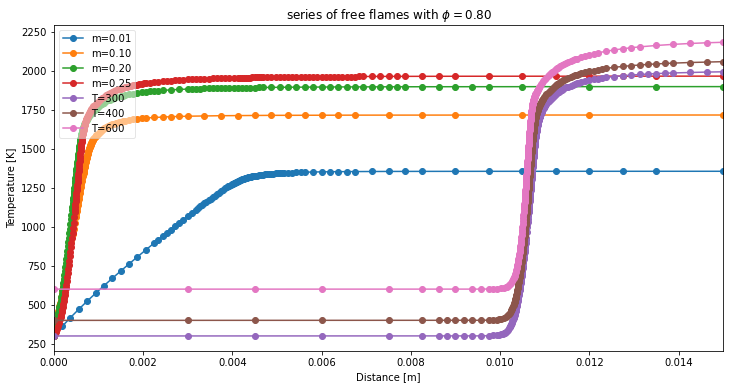

In [39]:
# let's plot some results. First we create an empty figure
plt.figure()
#We can globally change the figure size 
plt.rcParams['figure.figsize'] = [12, 6]
plt.xlim(0.00,0.015)
plt.plot(flamelist[0].grid,flamelist[0].T,'o-',label='m=0.01')
plt.plot(flamelist[2].grid,flamelist[2].T,'o-',label='m=0.10')
plt.plot(flamelist[4].grid,flamelist[4].T,'o-',label='m=0.20')
plt.plot(flamelist[5].grid,flamelist[5].T,'o-',label='m=0.25')
plt.plot(flamelist[6].grid,flamelist[6].T,'o-',label='T=300')
plt.plot(flamelist[7].grid,flamelist[7].T,'o-',label='T=400')
plt.plot(flamelist[9].grid,flamelist[9].T,'o-',label='T=600')
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
# place a semi-transparent legend on the figure at a specified location
plt.legend(framealpha=0.5,frameon=True,loc='upper left')
# show, the figure will be shown anyway but now the last command in the cell is show instead
# of another command, and the last command in the cell will be printed as well.
plt.show()

We have a nice set of solutions for different temperatures.

Now we interpolate these solutions onto a new grid with an equal number of points. Note that the grid is not *equidistant*, so the distance $\Delta x$ between the points is not a constant. Let's first interpolate the temperature. Let's do it for the free flames only.

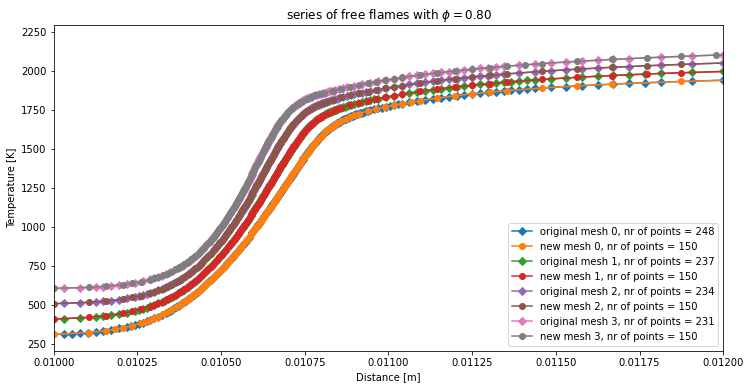

In [43]:
# intepolate onto new mesh
X0 = flamelist[6].grid
T0 = flamelist[6].T
X0new,T0new = newmesh(X0,T0,T0,150)
#H0=np.full((X0new.size,),flamelist[0].enthalpy_mass[0])

X1 = flamelist[7].grid
T1 = flamelist[7].T
X1new,T1new = newmesh(X1,T1,T1,150)
#H1=np.full((X1new.size,),flamelist[1].enthalpy_mass[1])

X2 = flamelist[8].grid
T2 = flamelist[8].T
X2new,T2new = newmesh(X2,T2,T2,150)
#H2=np.full((X2new.size,),flamelist[2].enthalpy_mass[2])

X3 = flamelist[9].grid
T3 = flamelist[9].T
X3new,T3new = newmesh(X3,T3,T3,150)
#H3=np.full((X3new.size,),flamelist[3].enthalpy_mass[3])

string1='original mesh 0, nr of points = '+str(len(X0))
string2='new mesh 0, nr of points = '+str(len(X0new))
string3='original mesh 1, nr of points = '+str(len(X1))
string4='new mesh 1, nr of points = '+str(len(X1new))
string5='original mesh 2, nr of points = '+str(len(X2))
string6='new mesh 2, nr of points = '+str(len(X2new))
string7='original mesh 3, nr of points = '+str(len(X3))
string8='new mesh 3, nr of points = '+str(len(X3new))

plt.xlim(0.010,0.012)
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('Temperature [K]')
# let's visualize temperature
plt.plot(X0,T0,'D-',label=string1)
plt.plot(X0new,T0new,'o-',label=string2)

plt.plot(X1,T1,'D-',label=string3)
plt.plot(X1new,T1new,'o-',label=string4)

plt.plot(X2,T2,'D-',label=string5)
plt.plot(X2new,T2new,'o-',label=string6)

plt.plot(X3,T3,'D-',label=string7)
plt.plot(X3new,T3new,'o-',label=string8)

plt.legend()
plt.show()

We see that the temperature on the new mesh is still accurate. We have used a very simple local refinement procedure based on temperature gradients. Any properties that have large gradients outside of the region with strong temperature gradients will not be represented accurately, e.g. species that are produces or consumed early or late in the flame front. Let's check the net production of some species. Our original meshes all a have different number of points! Let's look at the production of $CO_2$.

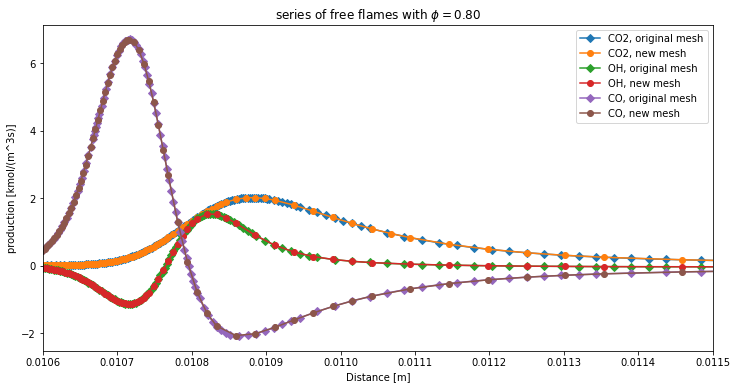

In [42]:
# intepolate onto new mesh
X0 = flamelist[6].grid
Y0 = flamelist[6].net_production_rates[gas.species_index('CO2')]
T0 = flamelist[6].T
X0new,Y0new = newmesh(X0,Y0,T0,150)

X1 = flamelist[7].grid
Y1 = flamelist[7].net_production_rates[gas.species_index('OH')]
T1 = flamelist[7].T
X1new,Y1new = newmesh(X1,Y1,T1,150)

X2 = flamelist[8].grid
Y2 = flamelist[8].net_production_rates[gas.species_index('CO')]
T2 = flamelist[8].T
X2new,Y2new = newmesh(X2,Y2,T2,150)


plt.xlim(0.0106,0.0115)
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production [kmol/(m^3s)]');

plt.plot(X0,Y0,'D-',label='CO2, original mesh')
plt.plot(X0new,Y0new,'o-',label='CO2, new mesh')

plt.plot(X1,Y1,'D-',label='OH, original mesh')
plt.plot(X1new,Y1new,'o-',label='OH, new mesh')

plt.plot(X2,Y2,'D-',label='CO, original mesh')
plt.plot(X2new,Y2new,'o-',label='CO, new mesh')

plt.legend()
plt.show()

we see that also for the production rate of $CO_2$, we capture the shape accurately. Note that the production rate is in kmol/m^3s and Fluent uses kg/m^3s, so we have to multiply by the molecular weight of the species to get the same units. The production of $CO_2$ can then be added as a source term to the transport equation of $CO_2$ (the progress variable). 

We can also check the interpolation in progress variable space:

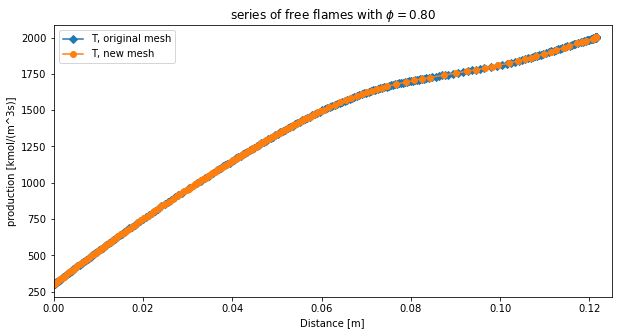

In [66]:
# intepolate onto new mesh
X0 = flamelist[6].grid
Y0 = flamelist[6].Y[gas.species_index('CO2')]
T0 = flamelist[6].T
X0new,Y0new = newmesh(X0,Y0,T0,150)
X0new,T0new = newmesh(X0,T0,T0,150)

plt.xlim(0.0,0.125)
plt.title('series of free flames with $\phi=0.80$')
plt.xlabel('Distance [m]')
plt.ylabel('production [kmol/(m^3s)]');

plt.plot(Y0,T0,'D-',label='T, original mesh')
plt.plot(Y0new,T0new,'o-',label='T, new mesh')

plt.legend()
plt.show()

We also see in the output for the burner stabilized flame that the enthalpy has lowered significantly (check this!). What is the lowest enthalpy that could occur? This happens when we let a completely burnt solution cool to room temperature. We can compute this using an equilibrium computation.

In [47]:
eq_gas = ct.Solution('gri30.xml')
eq_gas.transport_model = 'UnityLewis'
phi = 0.80
fuel_species = 'CH4'
air_composition='O2:0.21,N2:0.79'
eq_gas.TP = T_unburnt,p
eq_gas.set_equivalence_ratio(phi,fuel_species,air_composition)
#gas.TPX = 300.0, ct.one_atm, 'CH4:0.8,O2:2,N2:7.52'
eq_gas.equilibrate('TP')
eq_gas()


  gri30:

       temperature             300  K
          pressure          101325  Pa
           density         1.13164  kg/m^3
  mean mol. weight         27.8579  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -2.4379e+06       -6.791e+07     J
   internal energy     -2.5274e+06       -7.041e+07     J
           entropy          7199.2        2.006e+05     J/K
    Gibbs function     -4.5976e+06       -1.281e+08     J
 heat capacity c_p          1091.9        3.042e+04     J/K
 heat capacity c_v          793.48         2.21e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2      0.0387454        0.0445046         -27.9245
               H2O       0.154982         0.100224         -121.525
               CO2      0.0774908          0.12242         -186.031
               NO2    2.47

We see from the composition that the mixture is completely burned and the temperature is 300K. We also see that the total enthalpy of this mixture is $h=-2.4\cdot10^6 \frac{J}{kg}$. We can create a final flame with this equilibrium information and add it to our table. For this, we can simply copy the final composition $N_p$ times, which is the number of points in the progress variable direction. We do this in the code below, where we write the information of all our flames to a file.

We are going to create an FGM for use in Fluent. Fluent has a user defined function (UDF) that can read the FGM file. The FGM file starts with a header, containing information about the FGM. After constructing the header, we write the FGM data as column data in plain text format (ASCII format).

In [68]:
# write-fgm

# points in progress variable direction
# note that it does not make sense to use more points than the original flame solution has. We do not add any accuracy, only computation time, memory and disc space!

pvpoints = 150

# points in enthalpy direction. This is the number of flames that we have computed. We are not going to interpolate in the direction of enthalpy
enthpoints = len(flamelist)

strdatasize=str(pvpoints) + " " + str(enthpoints) + "\n"
strgridpower="1.0 1.0\n"
strpoints=str(pvpoints) + " " + str(enthpoints)
print(strpoints)

fgmheader=["[FGM]\n",
           "2DRLR\n",
           "[DIMENSION]\n",
           "2\n",
           "[CVDEFINITION]\n",
           "2\n",
           "CO2  1.0 0.0\n",
           "ENTHALPY 0.0 1.0\n",
           "[END]\n",
           "[DATASIZE]\n", 
           strdatasize, 
           "[GRIDPOWER]\n", 
           strgridpower,
           "[VARIABLES]\n",]

# these are the variables that we want to save to the FGM
varlist=["CV1\n",
         "CV2\n",
         "SOURCE_CV1\n",
         "SOURCE_CV2\n",
         "DIFF_CV1\n",
         "DIFF_CV2\n",
         "DENSITY\n",
         "TEMPERATURE\n",
         "CP\n",
         "CONDUCTIVITY\n", 
         "VISCOSITY\n", 
         "HEATRELEASE\n",
         "CH4\n",
         "CO\n",
         "CO2\n",
         "O2\n",
         "ENTHALPY\n",
        ]

print(varlist)

# in case we just want all the species, that's a bit too much
#for i, specie in enumerate(gas.species()):
#    varlist.append(str(specie).replace('<Species ','').replace('>','')+" \n")


# number of variables
numvar = len(varlist)
print(numvar)

# add the variables list to the header
fgmheader.append(str(numvar)+"\n")
fgmheader = fgmheader + varlist
fgmheader.append("[END]\n")
fgmheader.append("[DATA]\n")

print(fgmheader)

# open the file for writing, create if file does not exist, overwrite if file exists
fgmfile = open("database.fgm","w",newline='')

# write the header
fgmfile.writelines(fgmheader)

# first flamelet: the equilibrium flame solution
iPV=eq_gas.species_index('CO2')
CV1 = np.ones(pvpoints)*eq_gas.Y[iPV]
CV2 = np.ones(pvpoints)*eq_gas.enthalpy_mass
SOURCE_CV1=np.ones(pvpoints)*0.0
SOURCE_CV2=0.0
DIFF_CV1=0.0
DIFF_CV2=0.0
DENSITY=np.ones(pvpoints)*eq_gas.density
TEMPERATURE=np.ones(pvpoints)*eq_gas.T
CP=np.ones(pvpoints)*eq_gas.cp_mass
CONDUCTIVITY=np.ones(pvpoints)*eq_gas.thermal_conductivity
VISCOSITY=np.ones(pvpoints)*eq_gas.viscosity
HEATRELEASE=np.ones(pvpoints)*0.0
SPECIES1=np.ones(pvpoints)*eq_gas.Y[eq_gas.species_index('CH4')]
SPECIES2=np.ones(pvpoints)*eq_gas.Y[eq_gas.species_index('CO')]
SPECIES3=np.ones(pvpoints)*eq_gas.Y[eq_gas.species_index('CO2')]
SPECIES4=np.ones(pvpoints)*eq_gas.Y[eq_gas.species_index('O2')]
ENTHALPY=CV2
# loop over all points and write a line for each pv point
for i in range(0,pvpoints):
    fgmline = [CV1[i],CV2[i],
                SOURCE_CV1[i],SOURCE_CV2,
                DIFF_CV1,DIFF_CV2,
                DENSITY[i],
                TEMPERATURE[i],
                CP[i],
                CONDUCTIVITY[i],
                VISCOSITY[i],
                HEATRELEASE[i],
                SPECIES1[i],
                SPECIES2[i],
                SPECIES3[i],
                SPECIES4[i],
                ENTHALPY[i]]
    
    wr=csv.writer(fgmfile,delimiter=' ',lineterminator='\n')
    wr.writerow("%e" % item for item in fgmline)
# we have written the first flamelet: the equilibrium solution. Now we write the other flamelets.        

        
# now loop over the flames in flamelist and write the data

counter1=0
for f in flamelist:
    
    print("flame number ",counter1)
    
    # old mesh and temperature
    X = f.grid
    T = f.T

    # index to the species that acts as a progress variable (CO2)
    iPV=flame.gas.species_index('CO2')
    MolWeight_CO2 = flame.gas.molecular_weights[iPV]


    # first control variable: progress variable
    grid,CV1=newmesh(X,f.Y[iPV],T,pvpoints)
    
    # second control variable: enthalpy
    # for enthalpy we assume a constant value. We take the first value from the list
    #grid,ENTHALPY = newmesh(X,f.enthalpy_mass,T,pvpoints)
    ENTHALPY = np.ones(len(grid))*f.enthalpy_mass[0]
    CV2=ENTHALPY

    grid,SOURCE_CV1 = newmesh(X,f.net_production_rates[iPV],T,pvpoints)
    SOURCE_CV1 = SOURCE_CV1 * MolWeight_CO2
    SOURCE_CV2 = 0
    grid,CONDUCTIVITY = newmesh(X,f.thermal_conductivity,T,pvpoints)

    grid,CP = newmesh(X,f.cp_mass,T,pvpoints)

    grid,DENSITY = newmesh(X,f.density,T,pvpoints)

    DIFF_CV1 = 0
    DIFF_CV2 = 0

    grid,VISCOSITY=newmesh(X,f.viscosity,T,pvpoints)
    grid,TEMPERATURE=newmesh(X,f.T,T,pvpoints)
    grid,HEATRELEASE=newmesh(X,f.heat_release_rate,T,pvpoints)

    # which species do we want to write to the FGM?
    grid,SPECIES1 = newmesh(X,f.X[gas.species_index("CH4")],T,pvpoints)
    grid,SPECIES2 = newmesh(X,f.X[gas.species_index("CO")],T,pvpoints)
    grid,SPECIES3 = newmesh(X,f.X[gas.species_index("CO2")],T,pvpoints)
    grid,SPECIES4 = newmesh(X,f.X[gas.species_index("O2")],T,pvpoints)

 
    # write the data, loop over the enthalpy points
    # for i in range
    # write the data, loop over the progress variable points
    for i in range(0,pvpoints):
        fgmline = [CV1[i],CV2[i],
                   SOURCE_CV1[i],SOURCE_CV2,
                   DIFF_CV1,DIFF_CV2,
                   DENSITY[i],
                   TEMPERATURE[i],
                   CP[i],
                   CONDUCTIVITY[i],
                   VISCOSITY[i],
                   HEATRELEASE[i],
                   SPECIES1[i],
                   SPECIES2[i],
                   SPECIES3[i],
                   SPECIES4[i],
                   ENTHALPY[i]]
    
        wr=csv.writer(fgmfile,delimiter=' ',lineterminator='\n')
        wr.writerow("%e" % item for item in fgmline)

    counter1=counter1+1
    
# end of all data, close everything    
fgmfile.write("[END]")
fgmfile.close()

150 10
['CV1\n', 'CV2\n', 'SOURCE_CV1\n', 'SOURCE_CV2\n', 'DIFF_CV1\n', 'DIFF_CV2\n', 'DENSITY\n', 'TEMPERATURE\n', 'CP\n', 'CONDUCTIVITY\n', 'VISCOSITY\n', 'HEATRELEASE\n', 'CH4\n', 'CO\n', 'CO2\n', 'O2\n', 'ENTHALPY\n']
17
['[FGM]\n', '2DRLR\n', '[DIMENSION]\n', '2\n', '[CVDEFINITION]\n', '2\n', 'CO2  1.0 0.0\n', 'ENTHALPY 0.0 1.0\n', '[END]\n', '[DATASIZE]\n', '150 10\n', '[GRIDPOWER]\n', '1.0 1.0\n', '[VARIABLES]\n', '17\n', 'CV1\n', 'CV2\n', 'SOURCE_CV1\n', 'SOURCE_CV2\n', 'DIFF_CV1\n', 'DIFF_CV2\n', 'DENSITY\n', 'TEMPERATURE\n', 'CP\n', 'CONDUCTIVITY\n', 'VISCOSITY\n', 'HEATRELEASE\n', 'CH4\n', 'CO\n', 'CO2\n', 'O2\n', 'ENTHALPY\n', '[END]\n', '[DATA]\n']
flame number  0
flame number  1
flame number  2
flame number  3
flame number  4
flame number  5
flame number  6
flame number  7
flame number  8
flame number  9


An FGM was saved to a file and this file can now be used in Fluent. We can visualize the FGM.

In [69]:
# visualize the FGM. For this, we construct an array of all points (x,y), or in our case (c,h)

import matplotlib.tri as tri
plt.rcParams['figure.figsize'] = [16,12]

pvpoints = 150

# initialize the empty arrays
H = np.array([],dtype=float)
c = np.array([],dtype=float)
TEMPERATURE = np.array([],dtype=float)

# loop over flames and compute all the coordinates H,c and the values T
for i in range(len(flamelist)):
    # we reverse the order, so the highest enthalpy (the 'top' row) is first.
    j = len(flamelist)-i-1
    
    X = flamelist[j].grid
    T = flamelist[j].T
    
    #newmesh(X,f.X[gas.species_index("CH4")],T,pvpoints)
    h = np.full(pvpoints,flamelist[j].enthalpy_mass[0])
    H = np.concatenate((H,h))
    
    grid,CO2 = newmesh(X, flamelist[j].Y[gas.species_index("CO2")], T, pvpoints)
    c = np.concatenate((c,CO2))

    grid,T1 = newmesh(X,flamelist[j].T,T,pvpoints)
    TEMPERATURE = np.concatenate((TEMPERATURE,T1))
    
    
# add the equilibrium value at the bottom
eq_CV1 = np.ones(pvpoints)*eq_gas.Y[iPV]
eq_CV2 = np.ones(pvpoints)*eq_gas.enthalpy_mass
eq_TEMPERATURE=np.ones(pvpoints)*eq_gas.T
H = np.concatenate((H,eq_CV2))
c = np.concatenate((c,eq_CV1))
TEMPERATURE = np.concatenate((TEMPERATURE,eq_TEMPERATURE))

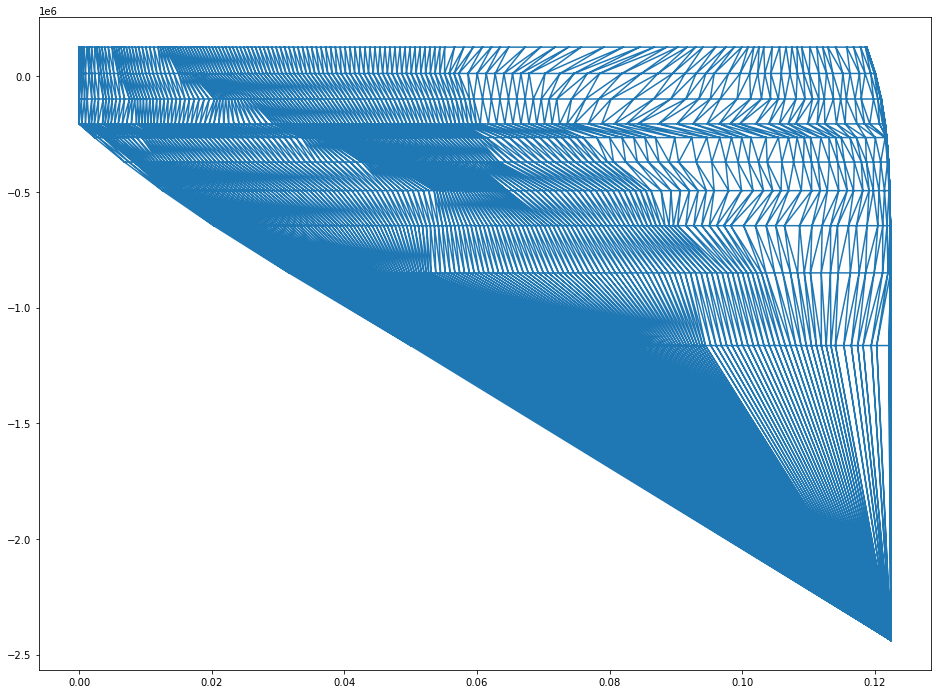

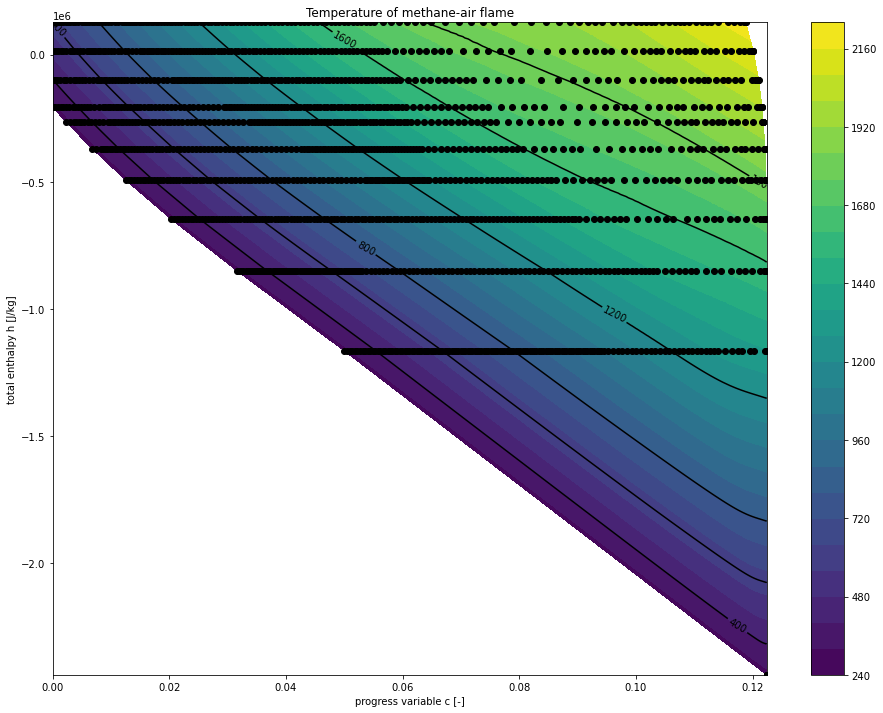

In [70]:
# construct a proper triangulation
npv=pvpoints
# number of flames + equilibrium point
nh=len(flamelist)+1

tria01 = np.ones(((npv-1)*(nh-1)*2,3),dtype=np.int32)
index=0

for j in range(nh-1):
    for i in range(npv-1):        
        tria01[index*2]   =[npv*j + i+1, npv*j + i,     (j+1)*npv+i]
        tria01[index*2+1] =[(j+1)*npv+i, (j+1)*npv+i+1, npv*j + i+1]
        index=index+1
        #print(index," ",i," ",j," (",npv*j + i+1, npv*j + i,(j+1)*npv+i,"),(",(j+1)*npv+i,(j+1)*npv+i+1,npv*j + i+1, ")")
    
# plot the mesh
plt.triplot(c, H,tria01)


# create a contour plot
fig, ax = plt.subplots()
ax.set_title('Temperature of methane-air flame')
ax.set_xlabel('progress variable c [-]')
ax.set_ylabel('total enthalpy h [J/kg]')
tcf = ax.tricontourf(c,H,tria01,TEMPERATURE, 30) # contour plot, using xx number of colored contour levels

# Define black line contour levels in temperature where we want lines to appear
levels = np.array([400, 600, 800, 1200, 1600, 1800])
# Set all contour level lines to black
line_colors = ['black' for l in tcf.levels]
cp = ax.tricontour(c, H, tria01,TEMPERATURE, levels=levels, colors=line_colors)
# format of label text on the contour lines, it is a float (real) with 0 digits. Positioning is automatic
ax.clabel(cp, fontsize=10, fmt='%.0f',colors=line_colors)

# colorbar
fig.colorbar(tcf)

# visualize data points
ax.plot(c,H, 'ko')

plt.show()

When visualizing the data points, we see that the free flames and burner stabilized flames fill the upper part of the FGM (the black dots). A large part of the lower enthalpy region is not covered by simulation data. Only the final, lowest enthalpy is computed by equilibrium chemistry. Everything between the last solution of the burner stabilized flame and the equilibrium chemistry solution is interpolated. Most reactions have stopped at these low enthalpies, so this is not a big problem. 

# Assignment 4.1
for unity Lewis number and $\phi=0.70$ you are going to create an FGM and save it to a file.  
1. First, solve a series of free flames with temperatures $Tu=[275,300,325,350,375,400,425,450,475,500,525,550,575,600]$.
2. Then, solve a series of burner stabilized flames. Use $T_u=275 K$ and starting from a mass flow rate $\dot m$ that is 90% of the maximum mass flow rate $\dot m_{max}$ of the free flame at $T_u=275K$. Decrease mdot in steps to 0.01. 
3. Finally, solve the equilibrium value flame. 
4. Add all the solutions together in a single flamelist and visualize the FGM. Visualize in progress variable - enthalpy space the temperature, the source term (net production rate) of $CO_2$ and the mass fraction of CO. Why does the FGM have a triangular shape? 
5. Save the file to database.fgm and open it in your favourite editor to inspect the contents. Use this file for your Fluent exercises.
6. Name 3 parameters used in the FGM creation that will (probably) lead to an improvement of the accuracy of the Fluent solution.

Hand in the python notebook. together with your Fluent assignment.